# This code build two simple LSTM models
- the first model, use five temperature datapoints to predict one temperature after 24 hours.
    - with 100 LSTM units, and connected to a fully connected hidden layer with 8 neurons (ReLU), and 1 hidden layer as output with linear activation function

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

data = pd.read_csv(csv_path) 

13568290/13568290 [==============================] - 2s 0us/step


In [7]:
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


<AxesSubplot: >

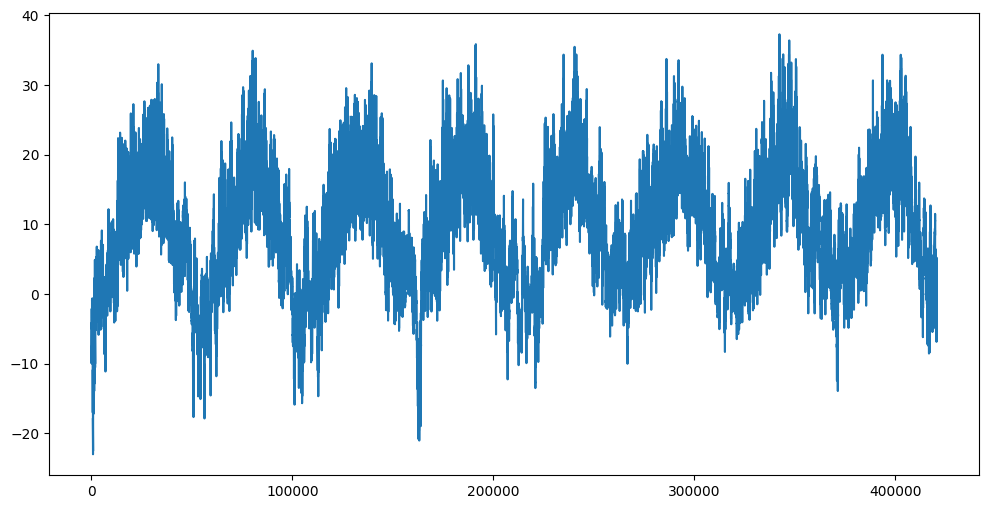

In [2]:
data['T (degC)'].plot(figsize=(12,6))

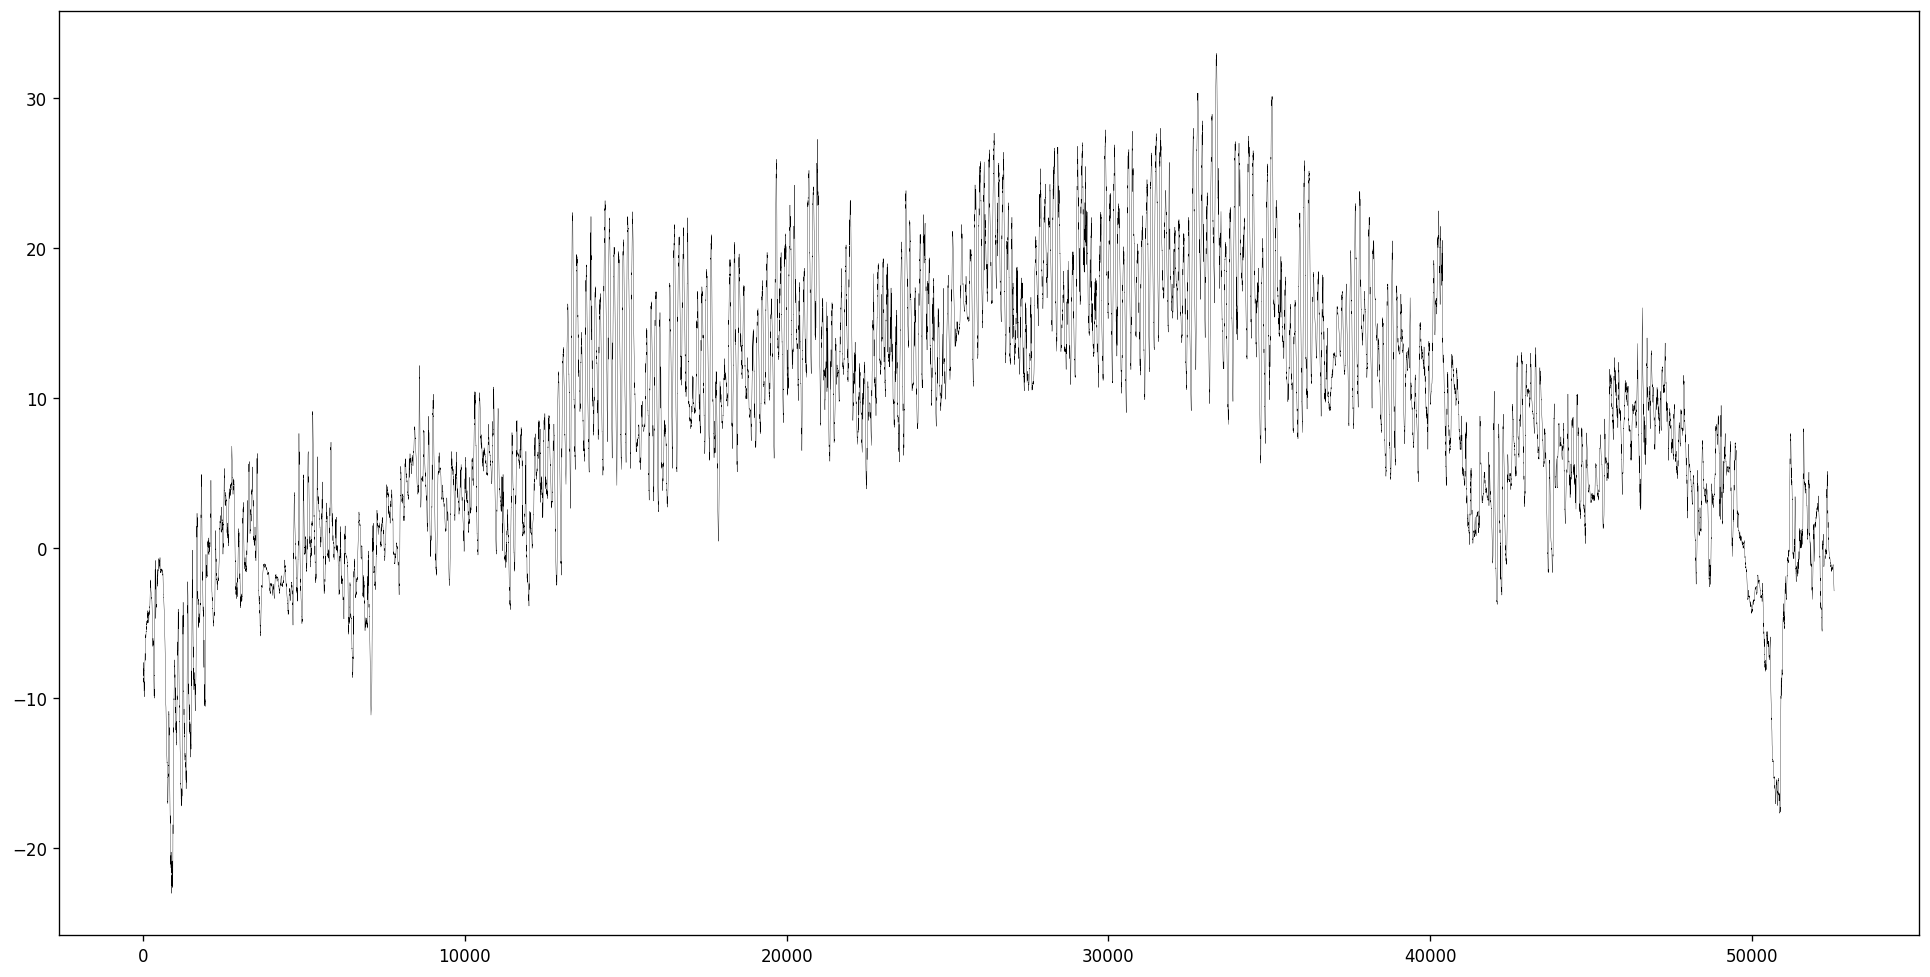

In [8]:
plt.figure(figsize=(20,10),dpi=120)
plt.plot(data['T (degC)'][0:6*24*365],color="black",linewidth=0.2)
plt.show()

In [29]:
len(data)

420551

In [9]:
# transform the data format
data.index = pd.to_datetime(data['Date Time'], format = "%d.%m.%Y %H:%M:%S") # europeean format
# use only point at 1 o'clock 2 o'clock ...
hourly = data[5::6]
# use temperature data
hourly_temp = hourly['T (degC)']
#[[[1],[2],[3],[4],[5]]][5+24]
#[[[2],[3],[4],[5],[6]]][6+24]
#[[[3],[4],[5],[6],[7]]][7+24]
# use date of 1 o'clock to 5 o'clock to predict 5+24=29 o'clock ...
# use date of 2 o'clock to 6 o'clock to predict 6+24=30 o'clock ...
def generator(data, window, offset):
    gen = data.to_numpy()
    X = []
    y = []
    for i in range(len(gen)-window-offset):
        row = [[a] for a in gen[i:i+window]]
        X.append(row)
        label = gen[i+window+offset-1]
        y.append(label)
    return np.array(X), np.array(y)
WINDOW = 5
OFFSET = 24
X, y = generator(hourly_temp, WINDOW, OFFSET)

#Train, valid and test sets
# train validate and test datasets
X_train, y_train = X[:60000], y[:60000]
X_val, y_val = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

# Tensorflow

from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# build LSTM model
# first layer: input layer
# second layer: LSTM layer, with 100 units
# third layer: fully connected layer, 8 neurons, with ReLU activation function
# forth layer: fully connected layer, 1 neuron, with linear activation function
#第四层是1个输出的全连接层，使用线性激活

model1 = Sequential()
model1.add(InputLayer((WINDOW, 1)))
model1.add(LSTM(100))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

In [12]:
cp = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
#########
# beging training the model
#########
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp])

Epoch 1/100
1864/1875 [============================>.] - ETA: 0s - loss: 11.0100 - root_mean_squared_error: 3.3181

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 10s 4ms/step - loss: 10.9972 - root_mean_squared_error: 3.3162 - val_loss: 10.9634 - val_root_mean_squared_error: 3.3111
Epoch 2/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.9784 - root_mean_squared_error: 3.3134 - val_loss: 11.0124 - val_root_mean_squared_error: 3.3185
Epoch 3/100
1863/1875 [============================>.] - ETA: 0s - loss: 10.9648 - root_mean_squared_error: 3.3113

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 8s 4ms/step - loss: 10.9632 - root_mean_squared_error: 3.3111 - val_loss: 10.7352 - val_root_mean_squared_error: 3.2765
Epoch 4/100
1857/1875 [============================>.] - ETA: 0s - loss: 10.9625 - root_mean_squared_error: 3.3110

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 8s 4ms/step - loss: 10.9541 - root_mean_squared_error: 3.3097 - val_loss: 10.7083 - val_root_mean_squared_error: 3.2724
Epoch 5/100
1875/1875 [==============================] - 5s 3ms/step - loss: 10.9427 - root_mean_squared_error: 3.3080 - val_loss: 10.7688 - val_root_mean_squared_error: 3.2816
Epoch 6/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.9315 - root_mean_squared_error: 3.3063 - val_loss: 10.9359 - val_root_mean_squared_error: 3.3070
Epoch 7/100
1862/1875 [============================>.] - ETA: 0s - loss: 10.9391 - root_mean_squared_error: 3.3074

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 8s 4ms/step - loss: 10.9267 - root_mean_squared_error: 3.3056 - val_loss: 10.7075 - val_root_mean_squared_error: 3.2722
Epoch 8/100
1875/1875 [==============================] - 5s 3ms/step - loss: 10.9156 - root_mean_squared_error: 3.3039 - val_loss: 10.7627 - val_root_mean_squared_error: 3.2806
Epoch 9/100
1875/1875 [==============================] - 5s 3ms/step - loss: 10.9065 - root_mean_squared_error: 3.3025 - val_loss: 10.7845 - val_root_mean_squared_error: 3.2840
Epoch 10/100
1875/1875 [==============================] - 5s 3ms/step - loss: 10.9089 - root_mean_squared_error: 3.3029 - val_loss: 10.8006 - val_root_mean_squared_error: 3.2864
Epoch 11/100
1872/1875 [============================>.] - ETA: 0s - loss: 10.8961 - root_mean_squared_error: 3.3009

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 8s 4ms/step - loss: 10.8969 - root_mean_squared_error: 3.3011 - val_loss: 10.7023 - val_root_mean_squared_error: 3.2714
Epoch 12/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.8822 - root_mean_squared_error: 3.2988 - val_loss: 10.8234 - val_root_mean_squared_error: 3.2899
Epoch 13/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.8845 - root_mean_squared_error: 3.2992 - val_loss: 10.8147 - val_root_mean_squared_error: 3.2886
Epoch 14/100
1874/1875 [============================>.] - ETA: 0s - loss: 10.8809 - root_mean_squared_error: 3.2986

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 8s 4ms/step - loss: 10.8789 - root_mean_squared_error: 3.2983 - val_loss: 10.6445 - val_root_mean_squared_error: 3.2626
Epoch 15/100
1875/1875 [==============================] - ETA: 0s - loss: 10.8715 - root_mean_squared_error: 3.2972

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 8s 4ms/step - loss: 10.8715 - root_mean_squared_error: 3.2972 - val_loss: 10.6264 - val_root_mean_squared_error: 3.2598
Epoch 16/100
1860/1875 [============================>.] - ETA: 0s - loss: 10.8844 - root_mean_squared_error: 3.2991

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 8s 4ms/step - loss: 10.8740 - root_mean_squared_error: 3.2976 - val_loss: 10.6186 - val_root_mean_squared_error: 3.2586
Epoch 17/100
1871/1875 [============================>.] - ETA: 0s - loss: 10.8719 - root_mean_squared_error: 3.2973

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 8s 5ms/step - loss: 10.8699 - root_mean_squared_error: 3.2969 - val_loss: 10.5947 - val_root_mean_squared_error: 3.2550
Epoch 18/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.8600 - root_mean_squared_error: 3.2955 - val_loss: 10.8097 - val_root_mean_squared_error: 3.2878
Epoch 19/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.8469 - root_mean_squared_error: 3.2935 - val_loss: 10.7193 - val_root_mean_squared_error: 3.2740
Epoch 20/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.8521 - root_mean_squared_error: 3.2943 - val_loss: 10.7598 - val_root_mean_squared_error: 3.2802
Epoch 21/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.8380 - root_mean_squared_error: 3.2921 - val_loss: 10.7562 - val_root_mean_squared_error: 3.2797
Epoch 22/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.8394 - root_mean_squared_error: 3.2923 - v

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 9s 5ms/step - loss: 10.8290 - root_mean_squared_error: 3.2907 - val_loss: 10.5681 - val_root_mean_squared_error: 3.2509
Epoch 24/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.8312 - root_mean_squared_error: 3.2911 - val_loss: 10.7009 - val_root_mean_squared_error: 3.2712
Epoch 25/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.8311 - root_mean_squared_error: 3.2911 - val_loss: 10.7314 - val_root_mean_squared_error: 3.2759
Epoch 26/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.8168 - root_mean_squared_error: 3.2889 - val_loss: 10.6821 - val_root_mean_squared_error: 3.2684
Epoch 27/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.8141 - root_mean_squared_error: 3.2885 - val_loss: 10.7162 - val_root_mean_squared_error: 3.2736
Epoch 28/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.8156 - root_mean_squared_error: 3.2887 - v

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 9s 5ms/step - loss: 10.8124 - root_mean_squared_error: 3.2882 - val_loss: 10.4947 - val_root_mean_squared_error: 3.2396
Epoch 30/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.8048 - root_mean_squared_error: 3.2871 - val_loss: 10.6292 - val_root_mean_squared_error: 3.2603
Epoch 31/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.8000 - root_mean_squared_error: 3.2863 - val_loss: 10.5877 - val_root_mean_squared_error: 3.2539
Epoch 32/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.7947 - root_mean_squared_error: 3.2855 - val_loss: 10.6033 - val_root_mean_squared_error: 3.2563
Epoch 33/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.7891 - root_mean_squared_error: 3.2847 - val_loss: 10.5520 - val_root_mean_squared_error: 3.2484
Epoch 34/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.7931 - root_mean_squared_error: 3.2853 - v

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 9s 5ms/step - loss: 10.7493 - root_mean_squared_error: 3.2786 - val_loss: 10.4750 - val_root_mean_squared_error: 3.2365
Epoch 52/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.7475 - root_mean_squared_error: 3.2783 - val_loss: 10.8204 - val_root_mean_squared_error: 3.2894
Epoch 53/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.7413 - root_mean_squared_error: 3.2774 - val_loss: 10.6266 - val_root_mean_squared_error: 3.2599
Epoch 54/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.7469 - root_mean_squared_error: 3.2782 - val_loss: 10.6162 - val_root_mean_squared_error: 3.2582
Epoch 55/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.7447 - root_mean_squared_error: 3.2779 - val_loss: 10.5964 - val_root_mean_squared_error: 3.2552
Epoch 56/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.7367 - root_mean_squared_error: 3.2767 - v

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 9s 5ms/step - loss: 10.7136 - root_mean_squared_error: 3.2732 - val_loss: 10.4689 - val_root_mean_squared_error: 3.2356
Epoch 78/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.7132 - root_mean_squared_error: 3.2731 - val_loss: 10.5622 - val_root_mean_squared_error: 3.2500
Epoch 79/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.7109 - root_mean_squared_error: 3.2727 - val_loss: 10.4902 - val_root_mean_squared_error: 3.2389
Epoch 80/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.7117 - root_mean_squared_error: 3.2729 - val_loss: 10.7708 - val_root_mean_squared_error: 3.2819
Epoch 81/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.7107 - root_mean_squared_error: 3.2727 - val_loss: 10.5613 - val_root_mean_squared_error: 3.2498
Epoch 82/100
1875/1875 [==============================] - 6s 3ms/step - loss: 10.7108 - root_mean_squared_error: 3.2727 - v

159/159 [==============================] - 0s 2ms/step


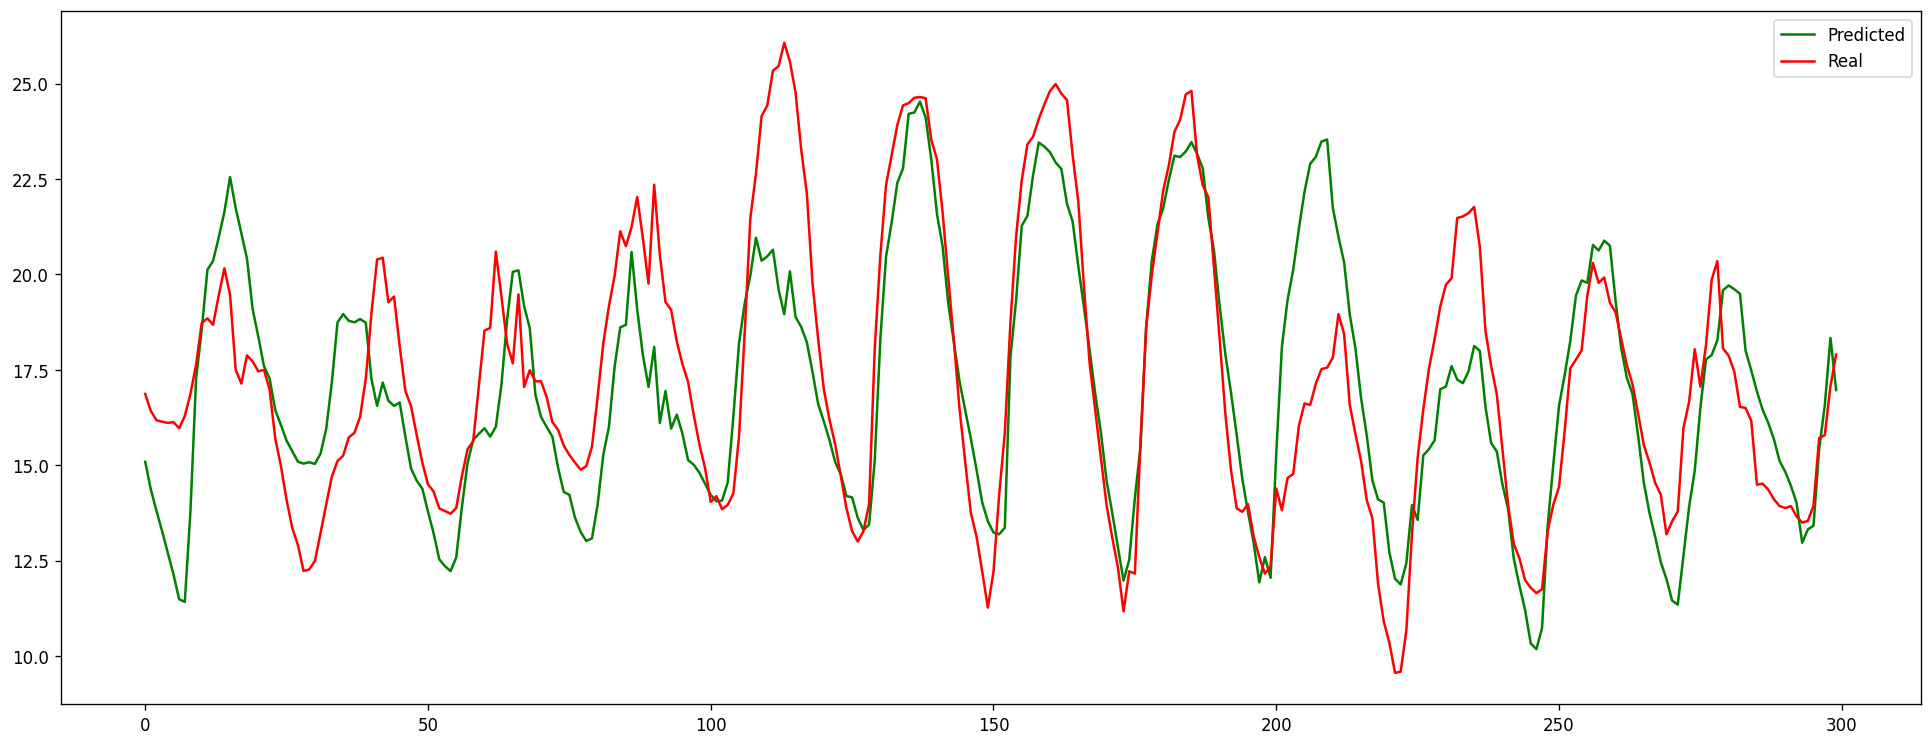

In [14]:
test_predictions = model1.predict(X_test).flatten()

result = pd.DataFrame(data={'Predicted': test_predictions, 'Real':y_test})
plt.figure(figsize=(20,7.5),dpi=120)
plt.plot(result['Predicted'][:300], "-g", label="Predicted")
plt.plot(result['Real'][:300], "-r", label="Real")
plt.legend()

In [30]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 8)                 808       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 41,617
Trainable params: 41,617
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 0.4816
Epoch 2/500
1/1 [==============================] - 0s 4ms/step - loss: 0.4294
Epoch 3/500
1/1 [==============================] - 0s 4ms/step - loss: 0.3791
Epoch 4/500
1/1 [==============================] - 0s 5ms/step - loss: 0.3308
Epoch 5/500
1/1 [==============================] - 0s 4ms/step - loss: 0.2853
Epoch 6/500
1/1 [==============================] - 0s 4ms/step - loss: 0.2437
Epoch 7/500
1/1 [==============================] - 0s 5ms/step - loss: 0.2076
Epoch 8/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1790
Epoch 9/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1600
Epoch 10/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1519
Epoch 11/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1540
Epoch 12/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1625
Epoch 13/500
1/1 [==============================] - 0s 3ms/ste

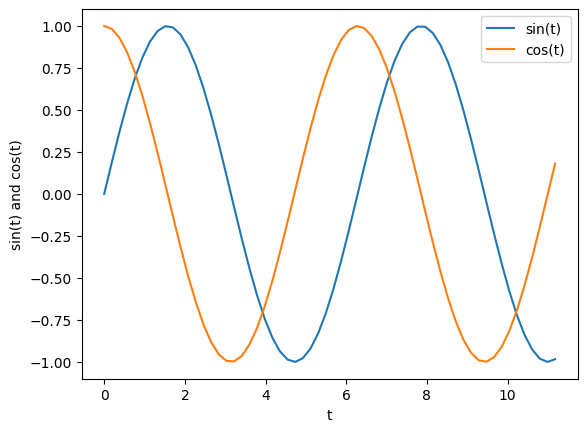

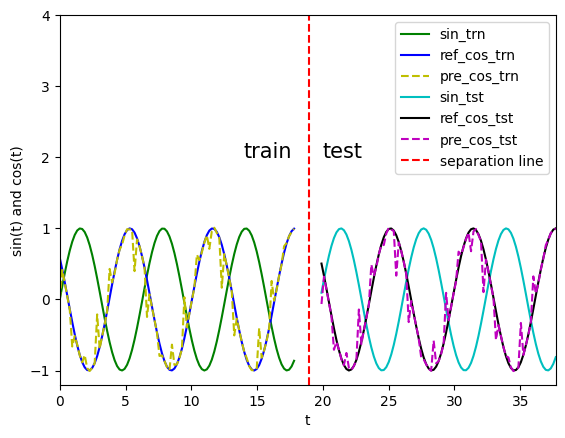

In [47]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define LSTM Neural Networks
class LstmRNN(tf.keras.Model):
    def __init__(self, hidden_size=1, output_size=1, num_layers=1):
        super(LstmRNN, self).__init__()
        self.lstm = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.dense = tf.keras.layers.Dense(output_size)
        
    def call(self, inputs):
        x = self.lstm(inputs)
        x = self.dense(x)
        return x

if __name__ == '__main__':
    # create database
    data_len = 200
    t = np.linspace(0, 12*np.pi, data_len)
    sin_t = np.sin(t)
    cos_t = np.cos(t)

    dataset = np.zeros((data_len, 2))
    dataset[:,0] = sin_t
    dataset[:,1] = cos_t
    dataset = dataset.astype('float32')

    # plot part of the original dataset
    plt.figure()
    plt.plot(t[0:60], dataset[0:60,0], label='sin(t)')
    plt.plot(t[0:60], dataset[0:60,1], label='cos(t)')
    plt.xlabel('t')
    plt.ylabel('sin(t) and cos(t)')
    plt.legend(loc='upper right')

    # choose dataset for training and testing
    train_data_ratio = 0.5 # Choose 50% of the data for training
    train_data_len = int(data_len * train_data_ratio)
    train_x = dataset[:train_data_len, 0][:-5]
    train_y = dataset[:train_data_len, 1][5:]
    test_x = dataset[train_data_len:, 0][:-5]
    test_y = dataset[train_data_len:, 1][5:]

    # Reshape the data for LSTM input
    train_x = np.reshape(train_x, (-1, 5, 1))
    train_y = np.reshape(train_y, (-1, 5, 1))
    test_x = np.reshape(test_x, (-1, 5, 1))

    # Create and compile the LSTM model
    lstm_model = LstmRNN(hidden_size=16, output_size=1, num_layers=1)
    lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss='mse')

    # Train the model
    max_epochs = 500
    history = lstm_model.fit(train_x, train_y, epochs=max_epochs, verbose=1)

    # Make predictions on training dataset
    predictive_y_for_training = lstm_model.predict(train_x)

    # Make predictions on test dataset
    predictive_y_for_testing = lstm_model.predict(test_x)

    # Plot the results
    plt.figure()
    plt.plot(t[:train_data_len-5], train_x.reshape(-1,1), 'g', label='sin_trn')
    plt.plot(t[:train_data_len-5], train_y.reshape(-1,1), 'b', label='ref_cos_trn')
    plt.plot(t[:train_data_len-5], predictive_y_for_training.reshape(-1,1), 'y--', label='pre_cos_trn')

    plt.plot(t[train_data_len+5:], test_x.reshape(-1,1), 'c', label='sin_tst')
    plt.plot(t[train_data_len+5:], test_y.reshape(-1,1), 'k', label='ref_cos_tst')
    plt.plot(t[train_data_len+5:], predictive_y_for_testing.reshape(-1,1), 'm--', label='pre_cos_tst')

    plt.plot([t[train_data_len], t[train_data_len]], [-1.2, 4.0], 'r--', label='separation line') # separation line

    plt.xlabel('t')
    plt.ylabel('sin(t) and cos(t)')
    plt.xlim(t[0], t[-1])
    plt.ylim(-1.2, 4)
    plt.legend(loc='upper right')
    plt.text(14, 2, "train", size = 15, alpha = 1.0)
    plt.text(20, 2, "test", size = 15, alpha = 1.0)

    plt.show()
